In [1]:
import os
import sys 
import glob
import dask
import pyproj
import copy
import dask
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
import xarray_sentinel
import dask.array as da
import drama.utils as drtls
import s1sea.geo_plot as gplt
from s1sea.cmod5n import cmod5n_inverse, cmod5n_forward
from s1sea.get_era5 import getera5
from s1sea.s1_preprocess import grd_to_nrcs, nrcs_to_roughness
from drama.performance.sar.antenna_patterns import sinc_bp, phased_array

from dataclasses import dataclass
from typing import Callable, Union, List, Dict, Any
from velocity_leakage import S1DopplerLeakage

/var/folders/90/d6h21jb17nz43871lx63sp_141mt08/T/ipykernel_86100/4148170149.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# importing from one directory  up
sys.path.insert(0, "../" )
from misc import round_to_hour, angular_difference, calculate_distance

In [3]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios = [ scenario for scenario in scenarios if "_" != scenario[0] ] 
scenarios

['Carrib_20231104',
 'Azores_20201127',
 'Hawaii_20201106',
 'Barbedos_20201110',
 'Aghulas_20200414',
 'Morroco_20201103',
 'Aghulas_20200121',
 'Aghulas_20191110',
 'Iceland_20231107',
 'Aghulas_20200426',
 'Scotland_20231109',
 'Aghulas_20200402',
 'Aghulas_20190515',
 'Aghulas_20200321']

In [13]:
scenario = 'Azores_20201127'
files = glob.glob(f"{data_dir+scenario}/*.SAFE")

test = S1DopplerLeakage(
    filename=files,
    # f0=26.5e9,
    era5_directory='era5_winds/',
    resolution_product=25_000,
    az_footprint_cutoff=80_000,
    vx_sat=6800,
    PRF=4,
    grid_spacing=6800/4/11,
    antenna_length=3.2,
    antenna_height=0.3,
    beam_pattern='phased_array',
    antenna_elements=4,
    antenna_weighting=0.5,
    incidence_angle_scat=40,

    # era5_smoothing_window=30,
    # denoise = True,
    # _pulsepair_noise = True
    # _speckle_noise= True
    )

/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/velocity_leakage.py:167: UserWarning: Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0
  warnings.warn("Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0")


In [14]:
# test.open_data()
# test.querry_era5()
# test.wdir_from_era5()
# test.create_dataset()
# test.create_beam_mask()
# test.compute_scatt_eqv_backscatter()
# test.compute_beam_pattern()
# test.compute_leakage_velocity()
# test.compute_leakage_velocity_estimate()
test.apply()

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Azores_20201127/A07B_B01D_CA05_CE1B_E23C_res154.54545454545453.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_wind_202011.nc


## Misc

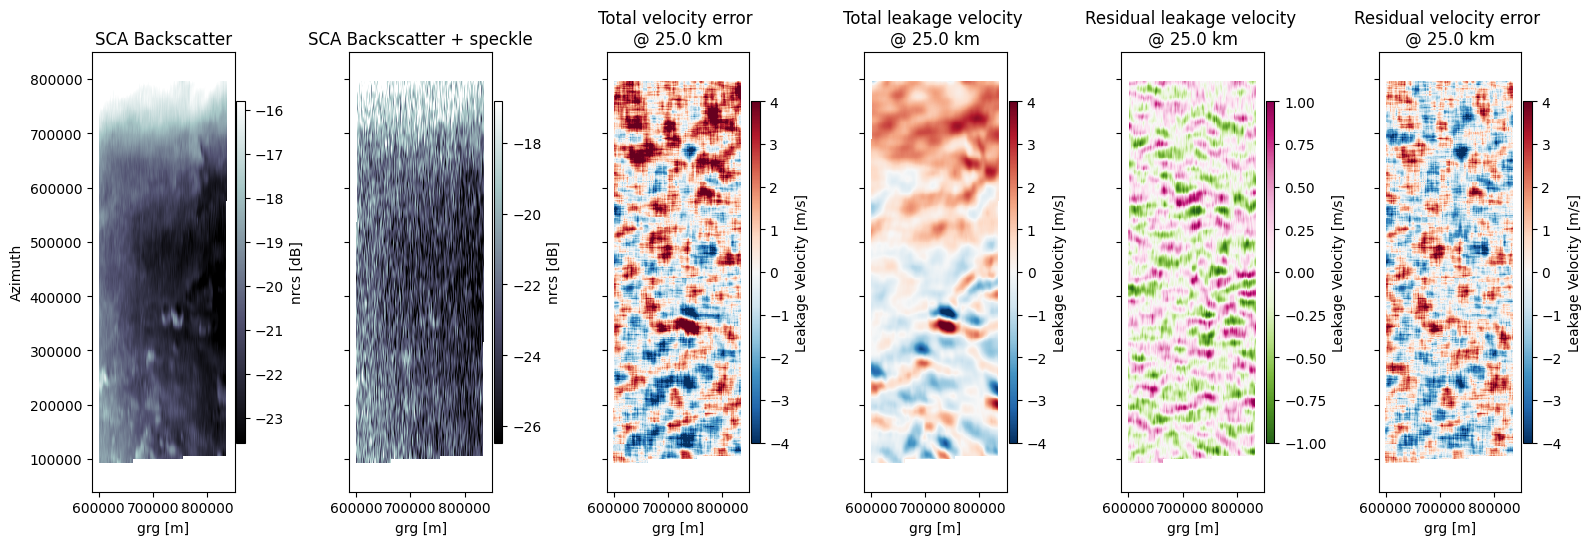

In [15]:
cbar_kwargs = {'shrink':0.7, 'aspect':40, 'pad' : 0.01, 'extend':'neither'}
plot_kwargs = {'robust': True}
plot_leakage_kwargs = {'vmin': -4, 'vmax': 4, 'cmap' : 'RdBu_r'}
plot_leakage_net_kwargs = {'vmin': -1, 'vmax': 1, 'cmap' : 'PiYG_r'}
label_kwargs = {'xlabel':'Range [m]', 'ylabel':'Azimuth [m]'}

net_leakage = test.data.V_leakage_pulse_rg_subscene - test.data.V_leakage_pulse_rg_subscene_inverted
net_velocity_error =  test.data.V_sigma_subscene - test.data.V_leakage_pulse_rg_subscene_inverted
nx = 6; ny = 1
fig, axes = plt.subplots(ny, nx, figsize = (16, 6), sharex=True, sharey=True)
axes_indexes = np.argwhere(axes)

plot_cut = net_velocity_error / net_velocity_error

(10*np.log10(test.data.nrcs_scat * plot_cut)).T.plot(ax= axes[*axes_indexes[0]],#[0,0], 
                                          **{'cmap': 'bone', **plot_kwargs},
                                          cbar_kwargs = {'label':'nrcs [dB]', **cbar_kwargs})
(10*np.log10(test.data.nrcs_scat_w_noise * plot_cut)).T.plot(ax= axes[*axes_indexes[1]],#[0,1], 
                                                  **{'cmap': 'bone', **plot_kwargs},
                                                  cbar_kwargs = {'label':'nrcs [dB]', **cbar_kwargs})
(test.data.V_sigma_subscene * plot_cut).T.plot(ax= axes[*axes_indexes[2]],#[0,2], 
                                             **{**plot_leakage_kwargs, **plot_kwargs},
                                             cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})
(test.data.V_leakage_pulse_rg_subscene * plot_cut).T.plot(ax= axes[*axes_indexes[3]],#[1,0],
                    **{**plot_leakage_kwargs, **plot_kwargs},
                    cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})
net_leakage.T.plot(ax= axes[*axes_indexes[4]],#[1,1],
                    **{**plot_leakage_net_kwargs, **plot_kwargs},
                    cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})
net_velocity_error.T.plot(ax= axes[*axes_indexes[5]],#[1,2],
                    **{**plot_leakage_net_kwargs, **plot_leakage_kwargs},
                    cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})

res = test.resolution_product/1000
titles = ['SCA Backscatter', 'SCA Backscatter + speckle', f'Total velocity error \n@ {res:2} km', 
          f'Total leakage velocity \n@ {res:2} km', f'Residual leakage velocity \n@ {res:2} km', f'Residual velocity error \n@ {res:2} km']
x_labels = [''] * (nx * np.max([0, ny-1])) + ['Range [m]'] * (nx * (ny-1))
y_labels = (['Azimuth'] + [''] * (nx - 1)) * ny
_ = [ax.axes.set_title(i) for ax, i in zip(axes.ravel(), titles)]
_ = [ax.axes.set_xlabel(i) for ax, i in zip(axes.ravel(), x_labels)]
_ = [ax.axes.set_ylabel(i) for ax, i in zip(axes.ravel(), y_labels)]
_ = [ax.axes.set_aspect('equal') for ax in axes.ravel()]

plt.tight_layout()

In [16]:
# np.sqrt(np.mean(net_velocity_error**2)).values
np.sqrt(np.mean(net_leakage**2)).values
# np.sqrt(np.mean(np.nanpercentile(net_leakage**2,90)))

# ax = grad.T.plot(robust = True)
# ax.axes.set_aspect('equal')

array(0.33000484, dtype=float32)

In [17]:
np.sqrt(np.mean(net_velocity_error**2)).values
# np.sqrt(np.mean(net_leakage**2)).values
# np.sqrt(np.mean(np.nanpercentile(net_leakage**2,90)))

# ax = grad.T.plot(robust = True)
# ax.axes.set_aspect('equal')

array(1.46838118)